In [39]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = 'EMB'  # emerging markets
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_emb.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%%**********************]  1 of 1 completed


Generating derived columns...
(4168, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
2007-12-19,101.040001,101.220001,101.040001,101.220001,45.748837,3.823166,1.001781,1.000396,1.000889
2007-12-20,101.309998,101.309998,101.260002,101.260002,45.766956,3.823562,0.999507,0.998912,1.002370
2007-12-21,101.500000,101.540001,101.029999,101.150002,45.717171,3.822474,0.996552,1.001781,1.001780
2007-12-24,101.330002,101.330002,101.330002,101.330002,45.798580,3.824253,1.000000,1.000789,0.999605
2007-12-26,101.290001,101.410004,101.290001,101.410004,45.834705,3.825042,1.001185,0.999220,0.998422
2007-12-27,101.250000,101.250000,101.099998,101.169998,45.798969,3.824262,0.999210,1.000394,1.000297
2007-12-28,101.199997,101.209999,101.169998,101.209999,45.817032,3.824656,1.000099,1.001384,1.001581
2007-12-31,101.370003,101.400002,101.349998,101.349998,45.880444,3.826039,0.999803,1.001381,0.998027
2008-01-02,101.150002,101.529999,101.150002,101.489998,45.943825,3.827419,1.003361,1.001773,1.002759


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
2007-12-19    101.220001
2007-12-20    101.309998
2007-12-21    101.540001
2007-12-26    101.410004
2007-12-27    101.250000
                 ...    
2024-07-08     89.500000
2024-07-09     89.370003
2024-07-10     89.589996
2024-07-11     90.339996
2024-07-12     90.379997
Name: high, Length: 4163, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2007-12-19')  # first day of legit open/close values
SIM_START

Timestamp('2007-12-19 00:00:00')

In [7]:
len(df.index >= SIM_START)

4168

In [9]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear']), #'linear_ma']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [10]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [11]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

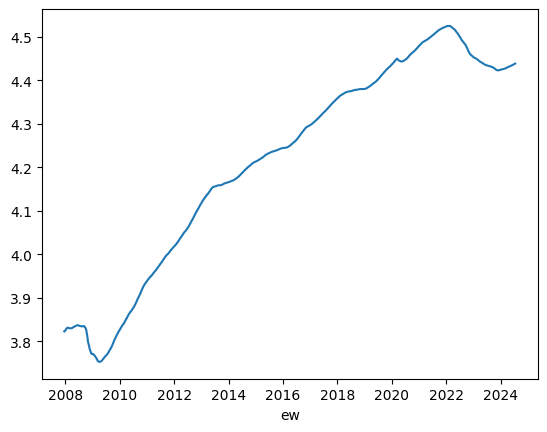

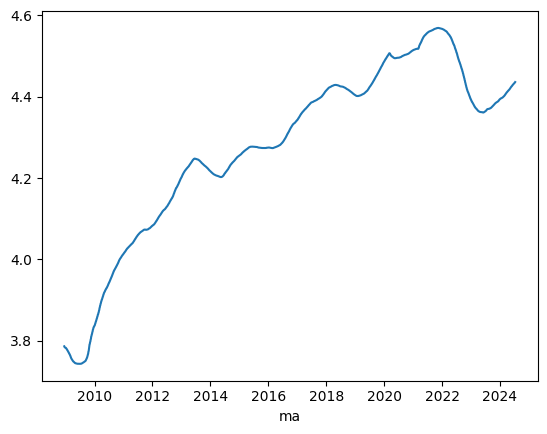

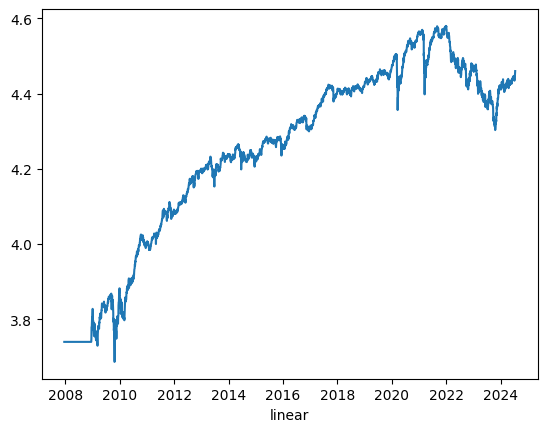

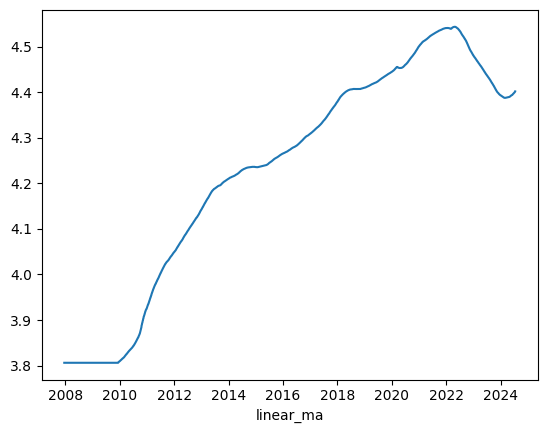

In [12]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [13]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [14]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [15]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [16]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [17]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [22]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params# = None, None

Do nothing res: 1.972946396178435
Round 1: 2.134809527999794
New best: 2.134809527999794
{'time_param': 30, 'method': 'ew', 't': 0.7470998622395322, 'k': 0.1336650049007495, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


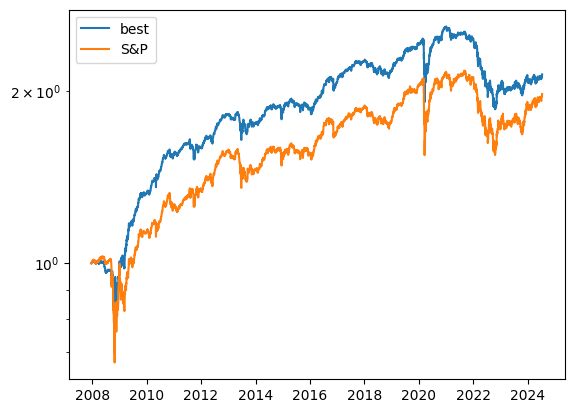

Round 2: nan
Round 3: 1.3733296316759385
Round 4: nan
Round 5: 1.2422159271688569
Round 6: nan
Round 7: nan
Round 8: nan
Round 9: 2.1550755758301148
New best: 2.1550755758301148
{'time_param': 89, 'method': 'linear', 't': 0.7641552585332299, 'k': 0.12221712399730479, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


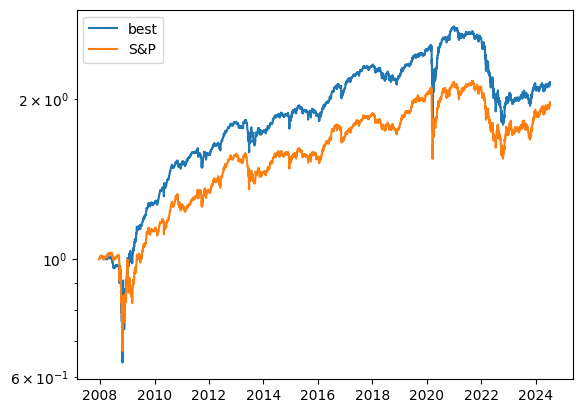

Round 10: nan
Round 11: 1.1781456072308418
Round 12: 1.9069998861062503
Round 13: nan
Round 14: nan
Round 15: 1.7180056230748038
Round 16: nan
Round 17: nan
Round 18: 1.742589931832077
Round 19: 1.3212168464447196
Round 20: nan
Round 21: nan
Round 22: 3.849616082635167
New best: 3.849616082635167
{'time_param': 62, 'method': 'linear', 't': 0.8880297537251247, 'k': 2.176158969824004, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


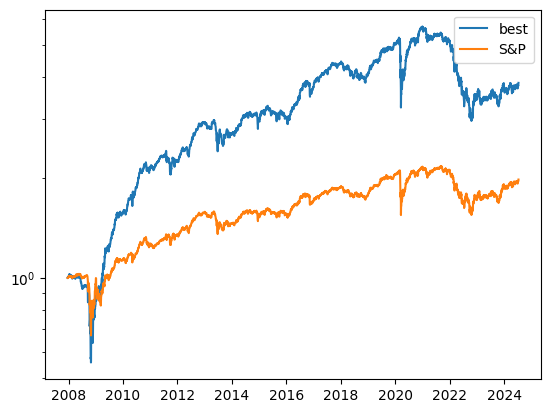

Round 23: 2.1013981975843246
Round 24: 1.9592366781378947
Round 25: 3.1238034045097933
Round 26: 1.8192578065936775
Round 27: nan
Round 28: 2.344598833969629
Round 29: 1.2096772008528631
Round 30: 3.969385576581044
New best: 3.969385576581044
{'time_param': 188, 'method': 'linear', 't': 0.9283760865109977, 'k': 5.006096275614166, 'as_q': False, 'transform_f': 'bounded_curve'}


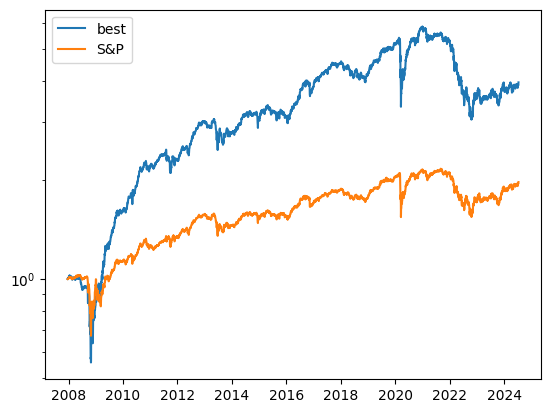

Round 31: nan
Round 32: 1.7700616559011557
Round 33: 1.0983063390859447
Round 34: 1.1281100119272671
Round 35: nan
Round 36: nan
Round 37: 1.1624904829372467
Round 38: 2.6160396034535323
Round 39: 1.5735214599694811
Round 40: 2.214611446762957
Round 41: 1.3773450243976488
Round 42: 1.1597848020885408
Round 43: 1.9853774351409426
Round 44: nan
Round 45: nan
Round 46: 1.1839308122415308
Round 47: 1.3210248905832591
Round 48: 3.960002589851503
Round 49: 1.4084438227051779
Round 50: 3.3699617587468937
Round 51: 1.9937992664696427
Round 52: 1.3071892094130284
Round 53: 2.0887647103775677
Round 54: 1.7817385914174118
Round 55: 1.2715634760762327
Round 56: 4.05921625604758
New best: 4.05921625604758
{'time_param': 218, 'method': 'linear', 't': 0.7660489377628537, 'k': 7.139642434323032, 'as_q': False, 'transform_f': 'bounded_curve'}


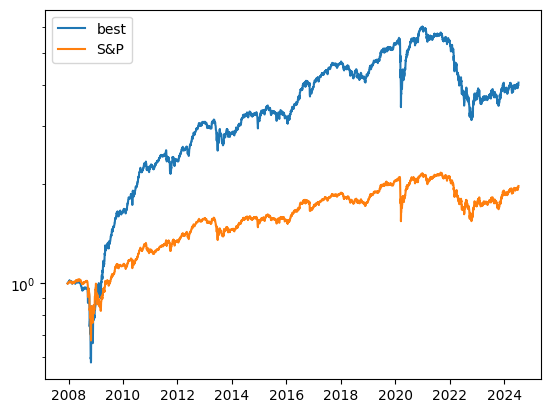

Round 57: 1.9906245868462353
Round 58: 2.0313334079630345
Round 59: 0.9010637177170117
Round 60: 1.1250735980521707
Round 61: 1.9971224393401763
Round 62: 2.3332121740655802
Round 63: 1.1484035902685044
Round 64: 1.5038032440498317
Round 65: nan
Round 66: 3.3603429874919053
Round 67: 1.7389438304545493
Round 68: 1.105743606229376
Round 69: 2.608997036485102
Round 70: nan
Round 71: 1.8639909821598368
Round 72: 3.514001463253937
Round 73: 1.3786918910292572
Round 74: nan
Round 75: 1.1316143282806737
Round 76: 1.2313872493747746
Round 77: 1.125549433182846
Round 78: nan
Round 79: 1.9531634280458452
Round 80: nan
Round 81: nan
Round 82: nan
Round 83: 1.9050442356930466
Round 84: 1.8015405022863271
Round 85: 2.9114506943241047
Round 86: 1.887307476043579
Round 87: 3.5795705749914
Round 88: 3.955369828578848
Round 89: 2.007226349732972
Round 90: 1.4181813649271708
Round 91: 1.3625105273655604
Round 92: 3.9092283857307253
Round 93: 1.1570544747366396
Round 94: 1.2135078113846374
Round 95: 1.2

In [23]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

Factor: 1.0625
Do nothing res: 1.972946396178435
Round 1: 3.969180905628467
Round 2: 3.9733779969491456
Round 3: 3.9374988172708423
Round 4: 3.9756494698344547
Round 5: 3.975232332308183
Round 6: 3.96796475027077
Round 7: 3.986849488261876
Round 8: 4.168811468767127
New best: 4.168811468767127
{'time_param': 219, 'method': 'linear', 't': 0.7126880756358429, 'k': 7.157051463636054, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


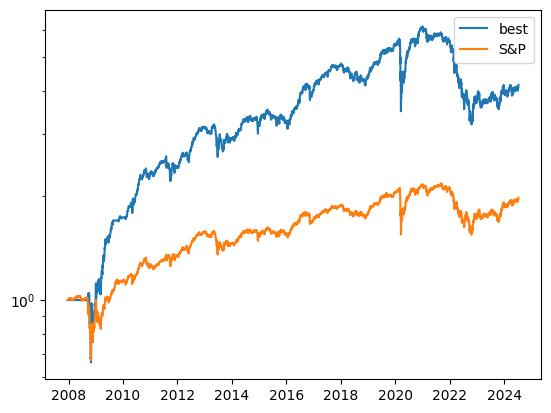

Round 9: 2.3898448824900447
Round 10: 1.5201503394072493
Round 11: 3.9440254522427525
Round 12: 1.544574353637291
Round 13: 3.9131208767297605
Round 14: 4.113832331394496
Round 15: 3.9574559462370003
Round 16: 3.9274917430282503
Round 17: 3.9607094063811212
Round 18: 4.255091323080448
New best: 4.255091323080448
{'time_param': 215, 'method': 'linear', 't': 0.6724835180449487, 'k': 7.235562777106807, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


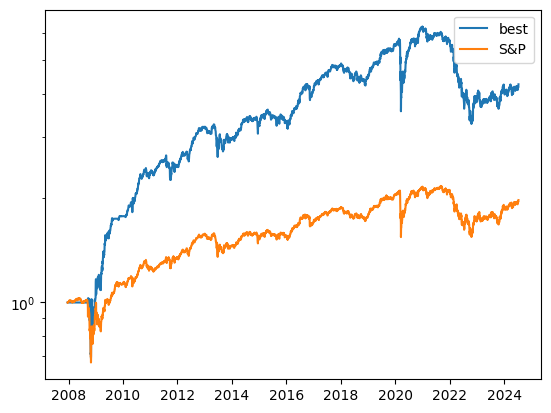

Round 19: 3.913031212611311
Round 20: 3.9161171187161012
Round 21: 1.535194752293415
Round 22: 3.953164891134109
Round 23: 1.7974859857297254
Round 24: 1.2856372655833248
Round 25: 1.0546613050244704

Factor: 1.03125
Do nothing res: 1.972946396178435
Round 1: 4.20377242691655
Round 2: 3.96433243348214
Round 3: 1.534224034910092
Round 4: 1.0567666515121379
Round 5: 3.935154199095102
Round 6: 1.497923937731473
Round 7: 4.18576388732051
Round 8: 1.5701691173196128
Round 9: 3.9861854459054937
Round 10: 3.911356333551248
Round 11: 1.4365386576196095
Round 12: 1.290747178951471
Round 13: 3.060867998058967
Round 14: 4.181407444016758
Round 15: 3.9167950228372033
Round 16: 1.0545413208229493
Round 17: 1.056980078544504
Round 18: 2.6108461010154715
Round 19: 2.1158313476908184
Round 20: 2.185663276300086
Round 21: 2.65824491022876
Round 22: 3.1107319426786044
Round 23: 3.7398709293038266
Round 24: 2.646381275983221
Round 25: 3.7562883308235073

Factor: 1.015625
Do nothing res: 1.972946396178435

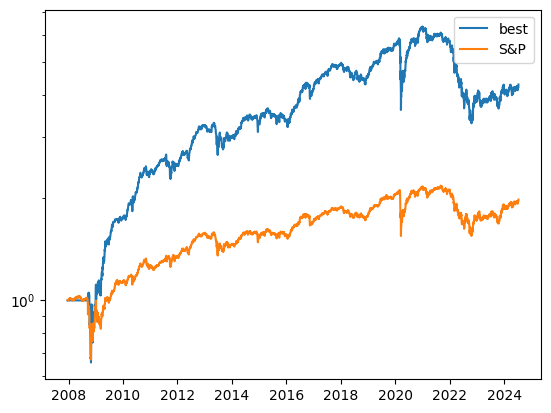

Round 22: 1.9724151023195193
Round 23: 4.231552451423894
Round 24: 1.4180627245198034
Round 25: 3.081434136718327

Factor: 1.0078125
Do nothing res: 1.972946396178435
Round 1: 3.9607094063811212
Round 2: 4.40608280949685
New best: 4.40608280949685
{'time_param': 217, 'method': 'linear', 't': 0.7303486226769511, 'k': 7.172304806712326, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


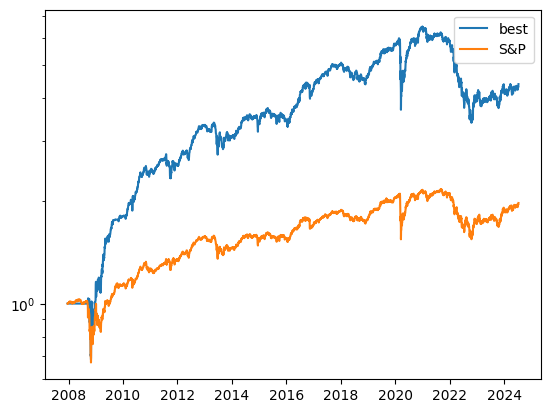

Round 3: 3.032971723308579
Round 4: 4.210507190769825
Round 5: 4.225914426417357
Round 6: 3.986849488256801
Round 7: 3.933149771989641
Round 8: 3.9331497719880546
Round 9: 3.986849488257183
Round 10: 1.8478638952637894
Round 11: 4.1708453100716
Round 12: 1.4980421868213363
Round 13: 3.929728038954993
Round 14: 1.8237864583519647
Round 15: 2.209274700921666
Round 16: 3.925888486514812
Round 17: 3.9433388165524565
Round 18: 2.1854326868174674
Round 19: 4.166349111291391
Round 20: 4.220266840948082
Round 21: 3.9607094063811212
Round 22: 4.198493261304713
Round 23: 3.06917481612132
Round 24: 3.9868494882563317
Round 25: 4.405173879529929



In [24]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

In [25]:
stop

NameError: name 'stop' is not defined

In [26]:
# Force set:
#best_out = 8.746647001172413
#params_out = {'time_param': 39, 'method': 'ma', 't': 0.9119734669470952, 'k': 6.934678320149607, 'as_q': True, 'transform_f': 'bounded_curve'}

In [27]:
final_out = simulate(df, params_out)

In [28]:
amt_in = final_out['amt_in'][-1]
amt_in

0.9993034691774755

In [29]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.5489103634537311

In [30]:
params_out

{'time_param': 217,
 'method': 'linear',
 't': 0.7303486226769511,
 'k': 7.172304806712326,
 'as_q': False,
 'transform_f': 'bounded_sigmoid'}

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


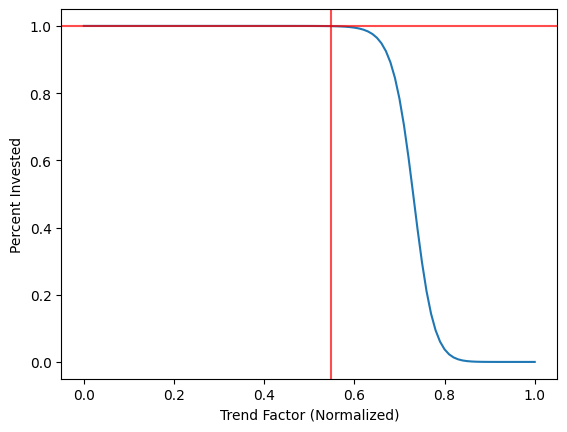

In [31]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

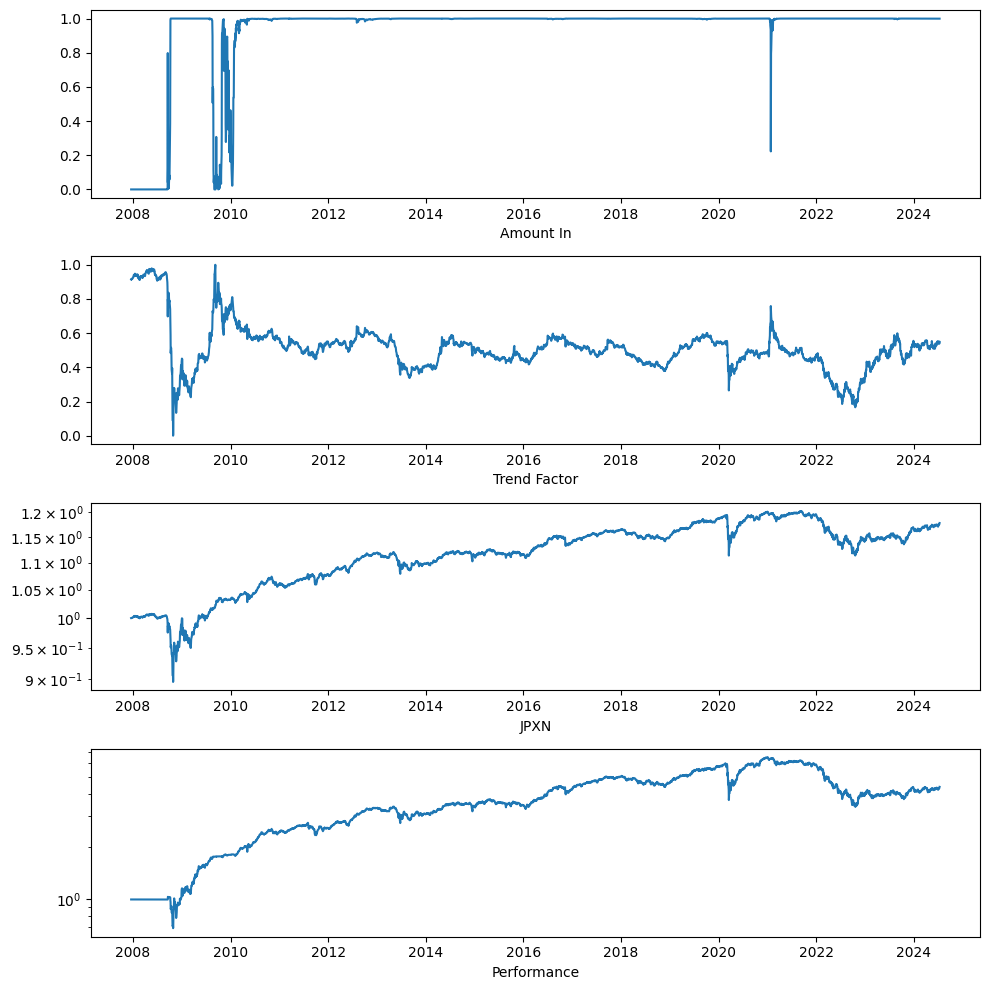

In [32]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('JPXN')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [33]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('Wilshire')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

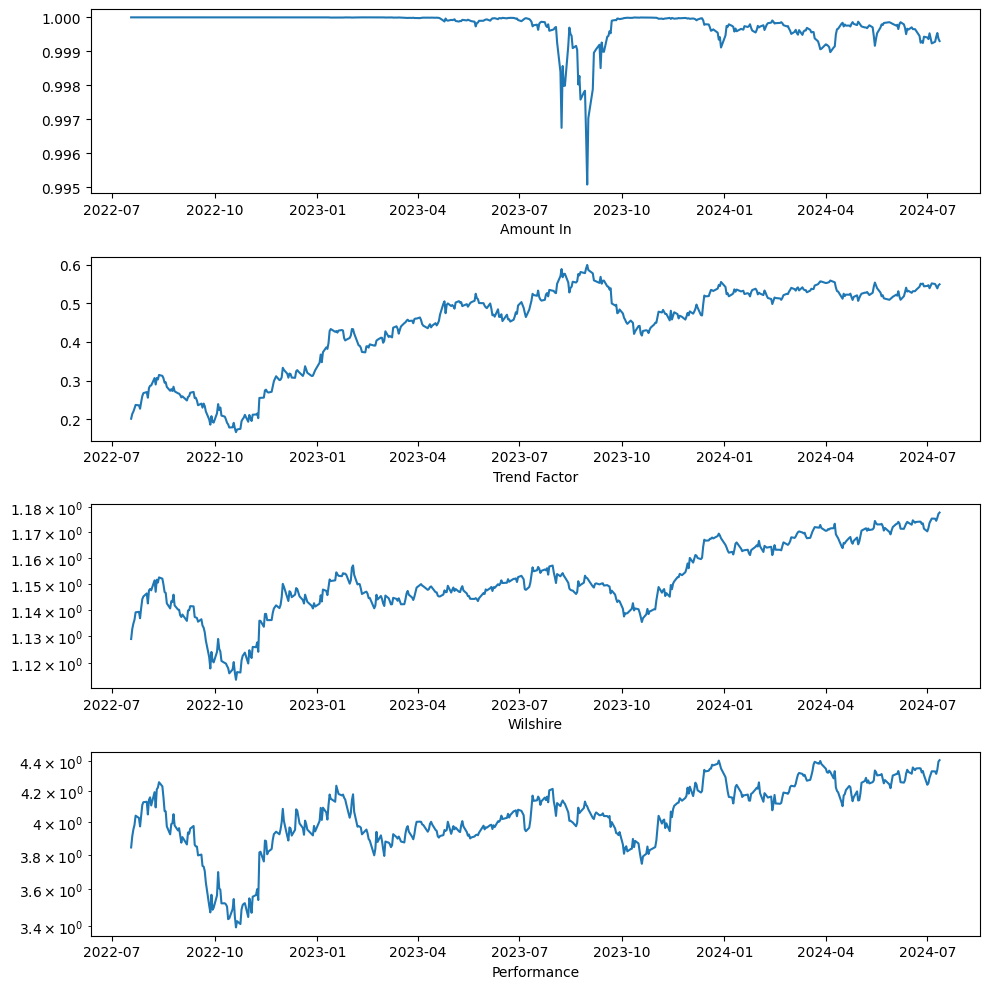

In [34]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('Wilshire')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [35]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(4.40608280949685,
 {'time_param': 217,
  'method': 'linear',
  't': 0.7303486226769511,
  'k': 7.172304806712326,
  'as_q': False,
  'transform_f': 'bounded_sigmoid'})

In [40]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

0.9993

In [41]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(45.748836517333984, 16.672, 90.26000213623047)

In [42]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.09302676697635048

In [43]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['emb'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.117876849072677, 0.9707], 'nas': [1.221824877675853, 0.9613], 'rus': [1.179140086085579, 0.7011], 'jpxn': [1.040675132153293, 0.4608], 'ktec': [1.6341335437597972, 0.0], 'emb': [1.0930267669763505, 0.9993]}
